In [1]:
# Livrable 2 - Traitement d'images



## 1. Chargement des données et constitution du jeu de données

In [2]:
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import time
import pandas as pd
import keras_tuner as kt
import tensorboard
from datetime import datetime
from packaging import version
from tensorflow.keras import regularizers


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
folder = pathlib.Path().resolve()
data_dir = str(folder / "data/Photo")

In [4]:
image_h = 180
image_w = 180
batch_s = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'))

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

10000
8000
2000


In [6]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_h, image_w])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [7]:
train = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [8]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), image_w, image_h, 3))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [9]:
# Loop through unbatched data
def unlabel(data, dataset):
    for image in dataset.as_numpy_iterator():
      data.append(image)

train_data, val_data = [], []
unlabel(train_data, train)
unlabel(val_data, val)
data_train = np.array(train_data, dtype=np.float32)
data_val = np.array(val_data, dtype=np.float32)

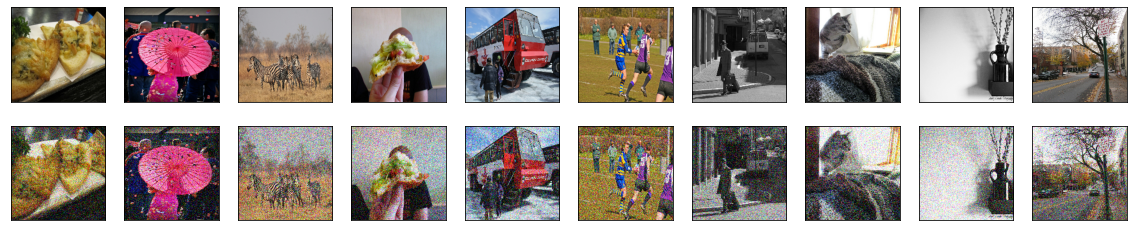

In [10]:
# Normalize and reshape the data
train_data = preprocess(data_train)
test_data = preprocess(data_val)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [13]:
# Configurations principales de nos modèles
IMG_SIZE          = 180                # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 50              # nombre epoch alogithme debruiter
BATCH_SIZE        = 128               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage

In [15]:
input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = keras.Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 90, 90, 32)       9248

In [17]:
# Train the model
history = autoencoder.fit(\
                          noisy_train_data, train_data,
                epochs=\
                NB_EPOCHS_DENOISE,#SOLUTION
                batch_size=\
                BATCH_SIZE,#SOLUTION
                shuffle=\
                True,#SOLUTION
                validation_data=(\
                                 noisy_test_data, test_data),
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
               )

Epoch 1/50
63/63 [==============================] - 268s 4s/step - loss: 0.6011 - val_loss: 0.5475
Epoch 2/50
63/63 [==============================] - 276s 4s/step - loss: 0.5457 - val_loss: 0.5414
Epoch 3/50
63/63 [==============================] - 390s 6s/step - loss: 0.5400 - val_loss: 0.5321
Epoch 4/50
63/63 [==============================] - 275s 4s/step - loss: 0.5301 - val_loss: 0.5269
Epoch 5/50
11/63 [====>.........................] - ETA: 3:24 - loss: 0.5290

KeyboardInterrupt: 

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(\
         history.history['loss'],#SOLUTION
         label='train')
plt.plot(\
         history.history['val_loss'],#SOLUTION
         label='test')
plt.legend()

In [ ]:
# save the model
autoencoder.save(SAV_MODEL_DENOISE) #SOLUTION